In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow_addons as tfa
from tensorflow.keras import mixed_precision

2024-10-28 05:21:23.803607: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 05:21:23.861500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 05:21:23.861538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 05:21:23.861571: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 05:21:23.871407: I tensorflow/core/platform/cpu_feature_g

# 데이터셋 로더

In [2]:
# **1. GPU 메모리 성장 설정 (가장 먼저 실행)**
physical_devices = tf.config.list_physical_devices('GPU')
for gpu in physical_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"메모리 성장 설정 완료: {gpu}")
    except RuntimeError as e:
        print(f"메모리 성장 설정 실패: {gpu} - {e}")

# **2. 분산 전략 설정**
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# **3. Mixed Precision 비활성화**
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

# **4. 데이터셋 로더 함수**
def load_data(csv_file, image_dir):
    df = pd.read_csv(csv_file)
    image_paths = df['image_path'].tolist()
    keypoints = df.iloc[:, 1:].values.astype(np.float32)
    return image_paths, keypoints

# **5. 키포인트 스케일링 함수 정의**
def scale_keypoints(keypoints, original_width=720, original_height=1280, target_size=224):
    keypoints = tf.convert_to_tensor(keypoints, dtype=tf.float32)
    x_coords = keypoints[::2]
    y_coords = keypoints[1::2]
    x_scale = target_size / original_width
    y_scale = target_size / original_height
    x_scaled = x_coords * x_scale
    y_scaled = y_coords * y_scale
    scaled_keypoints = tf.stack([x_scaled, y_scaled], axis=1)
    scaled_keypoints = tf.reshape(scaled_keypoints, [-1])
    return scaled_keypoints

# **6. 데이터 증강 함수 정의 (현재 사용 안 함)**
def augment(image, keypoints):
    # 랜덤 회전
    angle = tf.random.uniform([], -15, 15, dtype=tf.float32)
    angle_rad = angle * np.pi / 180.0
    image = tfa.image.rotate(image, angles=angle_rad, fill_mode='nearest')
    
    # 키포인트 회전
    center_x = 720.0 / 2 * (224 / 720.0)  # 224x224 이미지 기준 (720 -> 224)
    center_y = 1280.0 / 2 * (224 / 1280.0)  # 1280 -> 224
    rotation_matrix = tf.reshape([
        tf.cos(angle_rad), -tf.sin(angle_rad),
        tf.sin(angle_rad), tf.cos(angle_rad)
    ], [2, 2])
    keypoints = tf.reshape(keypoints, [NUM_KEYPOINTS, 2])
    keypoints = tf.matmul(keypoints - tf.constant([center_x, center_y]), rotation_matrix) + tf.constant([center_x, center_y])
    keypoints = tf.reshape(keypoints, [-1])
    
    return image, keypoints

# **7. 이미지 및 키포인트 전처리 함수 (종횡비 유지 및 패딩 추가)**
def preprocess_image(image_path, keypoints, image_dir, target_size=224, original_width=720, original_height=1280):
    """
    이미지와 키포인트를 전처리하는 함수.

    Parameters:
        image_path (tf.Tensor): 이미지 파일 경로.
        keypoints (tf.Tensor): 키포인트 좌표.
        image_dir (tf.Tensor): 이미지가 저장된 디렉토리 경로.
        target_size (int): 모델 입력 이미지의 크기.
        original_width (int): 원본 이미지의 너비.
        original_height (int): 원본 이미지의 높이.

    Returns:
        image (tf.Tensor): 전처리된 이미지.
        scaled_keypoints (tf.Tensor): 스케일 조정된 키포인트 좌표.
    """
    # 이미지 경로 결합
    image_full_path = tf.strings.join([image_dir, '/', image_path])
    
    # 이미지 로드 및 디코드
    image = tf.io.read_file(image_full_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # 이미지가 정상적으로 로드되었는지 확인하고, float32로 변환 및 [0,1] 범위로 스케일링
    image = tf.cond(tf.equal(tf.size(image), 0),
                   lambda: tf.zeros([target_size, target_size, 3], dtype=tf.float32),
                   lambda: tf.image.convert_image_dtype(image, tf.float32))
    
    # 원본 크기 가져오기
    orig_shape = tf.shape(image)[:2]
    orig_height_img = tf.cast(orig_shape[0], tf.float32)
    orig_width_img = tf.cast(orig_shape[1], tf.float32)
    
    # 종횡비 유지하며 리사이징
    scale = tf.minimum(target_size / orig_width_img, target_size / orig_height_img)
    new_width = tf.cast(tf.round(orig_width_img * scale), tf.int32)
    new_height = tf.cast(tf.round(orig_height_img * scale), tf.int32)
    
    image = tf.image.resize(image, [new_height, new_width])
    
    # 패딩 추가하여 타겟 사이즈 맞추기
    pad_width = target_size - new_width
    pad_height = target_size - new_height
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    
    image = tf.pad(image, [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], constant_values=0)
    
    # 키포인트 스케일 조정 및 이동
    keypoints = tf.convert_to_tensor(keypoints, dtype=tf.float32)
    x_coords = keypoints[::2]
    y_coords = keypoints[1::2]
    
    # 스케일링
    x_scale = scale
    y_scale = scale
    
    x_scaled = x_coords * x_scale + tf.cast(pad_left, tf.float32)
    y_scaled = y_coords * y_scale + tf.cast(pad_top, tf.float32)
    
    scaled_keypoints = tf.stack([x_scaled, y_scaled], axis=1)
    scaled_keypoints = tf.reshape(scaled_keypoints, [-1])
    
    return image, scaled_keypoints

# **8. 데이터셋 전처리 및 증강 함수**
def preprocess_image_aug(image_path, keypoints, image_dir, target_size=224, original_width=720, original_height=1280):
    image, keypoints = preprocess_image(image_path, keypoints, image_dir, target_size, original_width, original_height)
    image, keypoints = augment(image, keypoints)
    return image, keypoints

# **9. 데이터셋 생성 함수 수정**
def create_dataset(image_paths, keypoints, image_dir, batch_size=64, shuffle=True, augment_data=False, target_size=224, original_width=720, original_height=1280):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, keypoints))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    
    # image_dir을 TensorFlow 상수로 변환
    image_dir_tf = tf.constant(image_dir)
    
    if augment_data:
        # 데이터 증강 적용
        dataset = dataset.map(lambda x, y: preprocess_image_aug(x, y, image_dir_tf, target_size, original_width, original_height), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # 데이터 증강 미적용
        dataset = dataset.map(lambda x, y: preprocess_image(x, y, image_dir_tf, target_size, original_width, original_height), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
메모리 성장 설정 완료: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Number of devices: 3


2024-10-28 05:21:27.072575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-28 05:21:27.078280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-28 05:21:27.082099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# CSV 파일 경로
train_csv = 'keras_dataset/annotations/train_annotations.csv'
val_csv = 'keras_dataset/annotations/val_annotations.csv'

# 이미지 디렉토리
train_image_dir = 'keras_dataset/images/train'
val_image_dir = 'keras_dataset/images/val'

# 로드된 데이터
train_image_paths, train_keypoints = load_data(train_csv, train_image_dir)
val_image_paths, val_keypoints = load_data(val_csv, val_image_dir)

# 전체 배치 크기 설정
BATCH_SIZE_PER_REPLICA = 16  # 각 GPU당 배치 크기 (메모리 문제를 방지하기 위해 줄임)
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync  # 전체 배치 크기

# 훈련 및 검증 데이터셋 생성
train_dataset = create_dataset(
    train_image_paths, 
    train_keypoints, 
    train_image_dir, 
    batch_size=GLOBAL_BATCH_SIZE, 
    shuffle=True, 
    augment_data=False,  # 현재 데이터 증강 비활성화
    target_size=224, 
    original_width=720, 
    original_height=1280
)

val_dataset = create_dataset(
    val_image_paths, 
    val_keypoints, 
    val_image_dir, 
    batch_size=GLOBAL_BATCH_SIZE, 
    shuffle=False, 
    augment_data=False, 
    target_size=224, 
    original_width=720, 
    original_height=1280
)

# 키포인트 시각화

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 데이터셋 일부 시각화 (디버깅 용도)
def visualize_sample(image, keypoints, title='Sample'):
    image_np = image.numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    # 키포인트를 224x224 이미지에 맞게 그리기
    x = keypoints[::2].numpy()
    y = keypoints[1::2].numpy()
    plt.scatter(x, y, c='r', s=10)
    plt.title(title)
    plt.axis('off')
    plt.show()


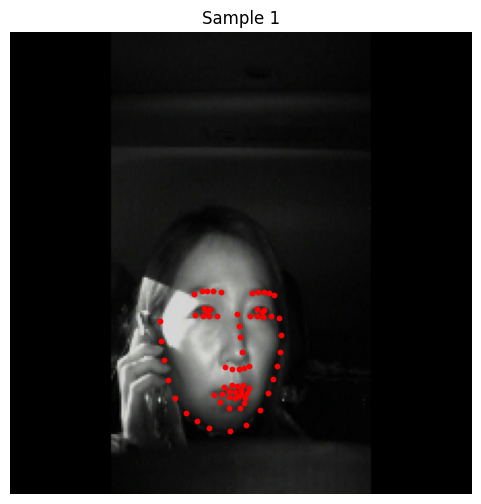

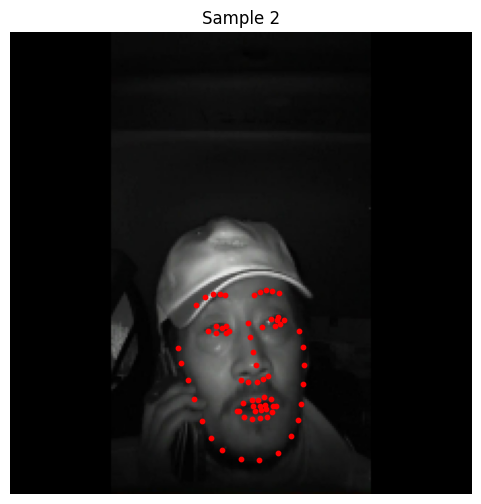

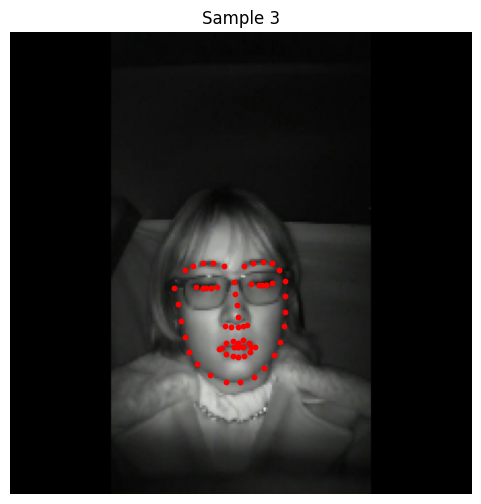

In [5]:
# 데이터셋에서 샘플 가져오기
for images, keypoints in train_dataset.take(1):
    for i in range(3):  # 첫 3개 샘플 시각화
        visualize_sample(images[i], keypoints[i], title=f"Sample {i+1}")

# 모델학습

In [6]:
import keras

# 키포인트 수
NUM_KEYPOINTS = 70

# 전략 범위 내에서 모델 정의 및 컴파일
with strategy.scope():
    # 백본 모델 로드 (pre-trained MobileNetV2)
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    
    # 백본 모델 고정
    # base_model.trainable = False
    
    # 글로벌 풀링
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    
    # 출력 레이어: 70개의 키포인트, 각 키포인트에 대해 x, y 좌표
    x = Dense(NUM_KEYPOINTS * 2, activation='linear', dtype='float32')(x)  # mixed precision 시 출력 dtype 설정
    
    # 모델 정의
    model = Model(inputs=base_model.input, outputs=x)
    
    # 모델 컴파일
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# 모델 요약 출력
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
# 콜백 설정
checkpoint = ModelCheckpoint('b16_lr001.h5', monitor='val_loss', save_best_only=True, verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# 모델 훈련
EPOCHS = 100

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint]
)

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 158 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 158 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-10-28 05:22:24.451990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-10-28 05:22:24.467089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-10-28 05:22:24.487155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-10-28 05:22:28.029979: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc6d7420710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-28 05:22:28.030026: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-28 05:22:28.030033: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-10-28 05:22:28.030039: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2024-10-28 05:22:28.039863: I ten

856/856 [==============================] - ETA: 0s - loss: 936.6008 - mae: 16.5950
Epoch 1: val_loss improved from inf to 663.65753, saving model to b16_lr001.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


856/856 [==============================] - 234s 198ms/step - loss: 936.6008 - mae: 16.5950 - val_loss: 663.6575 - val_mae: 21.9923
Epoch 2/100
856/856 [==============================] - ETA: 0s - loss: 38.2587 - mae: 4.8392
Epoch 2: val_loss improved from 663.65753 to 269.20139, saving model to b16_lr001.h5
856/856 [==============================] - 162s 189ms/step - loss: 38.2587 - mae: 4.8392 - val_loss: 269.2014 - val_mae: 14.0423
Epoch 3/100
856/856 [==============================] - ETA: 0s - loss: 30.5274 - mae: 4.3352
Epoch 3: val_loss improved from 269.20139 to 133.36177, saving model to b16_lr001.h5
856/856 [==============================] - 159s 184ms/step - loss: 30.5274 - mae: 4.3352 - val_loss: 133.3618 - val_mae: 9.2837
Epoch 4/100
856/856 [==============================] - ETA: 0s - loss: 28.0682 - mae: 4.1584
Epoch 4: val_loss did not improve from 133.36177
856/856 [==============================] - 164s 191ms/step - loss: 28.0682 - mae: 4.1584 - val_loss: 7242.5381 - v